In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from cuml.metrics.cluster import silhouette_score
from cuml import DBSCAN
import time
%matplotlib inline

In [2]:
df = pd.read_csv("diabetes_dataset.csv")
labels = df['diabetes']
#remove class label diabetes
df = df.drop(['diabetes'], axis=1)
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90


In [3]:
#function to get race label
def label_race(row):
    if row['race:AfricanAmerican']==1:
        return 'African American'
    if row['race:Asian']==1:
        return 'Asian'
    if row['race:Caucasian']==1:
        return 'Caucasian'
    if row['race:Hispanic']==1:
        return 'Hispanic'
    return 'Other'
df['race_label'] = df.apply(label_race, axis=1)
df = df.drop(['race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other'], axis=1)
df.head()

,year,gender,age,location,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,race_label
0,2020,Female,32.0,Alabama,0,0,never,27.32,5.0,100,Other
1,2015,Female,29.0,Alabama,0,0,never,19.95,5.0,90,Asian
2,2015,Male,18.0,Alabama,0,0,never,23.76,4.8,160,Other
3,2015,Male,41.0,Alabama,0,0,never,27.32,4.0,159,Caucasian
4,2016,Female,52.0,Alabama,0,0,never,23.75,6.5,90,African American


In [4]:
le = LabelEncoder()
categorical = ['gender', 'location', 'smoking_history', 'race_label']
for variable in categorical:
    df[variable] = le.fit_transform(df[variable])
df.head()

,year,gender,age,location,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,race_label
0,2020,0,32.0,0,0,0,4,27.32,5.0,100,4
1,2015,0,29.0,0,0,0,4,19.95,5.0,90,1
2,2015,1,18.0,0,0,0,4,23.76,4.8,160,4
3,2015,1,41.0,0,0,0,4,27.32,4.0,159,2
4,2016,0,52.0,0,0,0,4,23.75,6.5,90,0


In [5]:
cols = df.columns
ms = MinMaxScaler()
df = ms.fit_transform(df)
df = pd.DataFrame(df, columns=[cols])
df.head()

,year,gender,age,location,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,race_label
0,0.714286,0.0,0.399399,0.0,0.0,0.0,0.8,0.202031,0.272727,0.090909,1.00
1,0.000000,0.0,0.361862,0.0,0.0,0.0,0.8,0.116013,0.272727,0.045455,0.25
2,0.000000,0.5,0.224224,0.0,0.0,0.0,0.8,0.160481,0.236364,0.363636,1.00
3,0.000000,0.5,0.512012,0.0,0.0,0.0,0.8,0.202031,0.090909,0.359091,0.50
4,0.142857,0.0,0.649650,0.0,0.0,0.0,0.8,0.160364,0.545455,0.045455,0.00


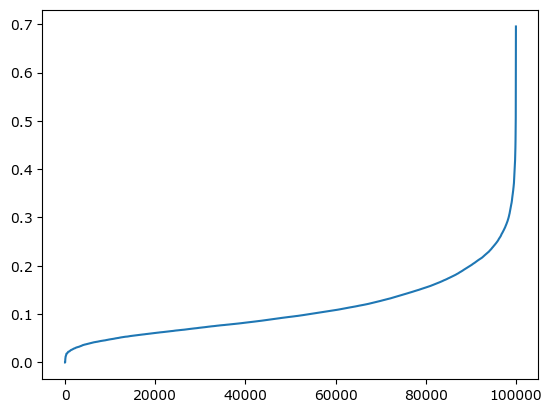

In [8]:
from cuml.neighbors import NearestNeighbors

#find a good range of epsilon using k=2*dim, then test
neighbors = NearestNeighbors(n_neighbors=22)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [6]:
# Defining the list of hyperparameters to try
eps_list=np.arange(start=0.2, stop=0.31, step=0.01)
min_sample_list=np.arange(start=12, stop=23, step=1)

# Creating empty data frame to store the silhouette scores for each trials
silhouette_scores_data=pd.DataFrame()
 
for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        if(len(np.unique(db.fit_predict(df)))>1):
            sil_score=silhouette_score(df, db.fit_predict(df))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial) +" min_sample :" + str(min_sample_trial)
        
        silhouette_scores_data=pd.concat([silhouette_scores_data, pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"])])
    print("eps=%f done" % eps_trial)
 
# Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False).head(1)

eps=0.200000 done
eps=0.210000 done
eps=0.220000 done
eps=0.230000 done
eps=0.240000 done
eps=0.250000 done
eps=0.260000 done
eps=0.270000 done
eps=0.280000 done
eps=0.290000 done
eps=0.300000 done


,score,parameters
0,0.083822,eps:0.3 min_sample :20


In [6]:
#find time taken (rmb to re-run this individually)
db = DBSCAN(eps=0.3, min_samples=20)
start_time = time.time()
db.fit(df)
end_time = time.time()
end_time-start_time

5.0662841796875

In [7]:
no_clusters = len(np.unique(db.labels_))
no_noise = np.sum(np.array(db.labels_) == -1, axis=0)
if (no_clusters>2):
    no_clusters -= 1
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 9
Estimated no. of noise points: 8107


In [8]:
db_label = pd.DataFrame(db.labels_, columns=['Cluster'])
df_new = pd.concat([df, db_label], axis=1)
df_new = df_new.loc[df_new['Cluster']!=-1]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91893 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   (year,)                 91893 non-null  float64
 1   (gender,)               91893 non-null  float64
 2   (age,)                  91893 non-null  float64
 3   (location,)             91893 non-null  float64
 4   (hypertension,)         91893 non-null  float64
 5   (heart_disease,)        91893 non-null  float64
 6   (smoking_history,)      91893 non-null  float64
 7   (bmi,)                  91893 non-null  float64
 8   (hbA1c_level,)          91893 non-null  float64
 9   (blood_glucose_level,)  91893 non-null  float64
 10  (race_label,)           91893 non-null  float64
 11  Cluster                 91893 non-null  int32  
dtypes: float64(11), int32(1)
memory usage: 8.8 MB


In [9]:
#silhouette score after removing noise
df_cluster = df_new['Cluster']
df2 = df_new.drop('Cluster', axis=1)
silhouette_score(df2, df_cluster)

0.11892567468706614